# import library

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_class_weight

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

import lightgbm as lgb
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

# merge data

In [ ]:
data_path = '/home/agung/Documents/alcr/ABC2026 Sozolab Challenge-20260110T085845Z-1-001/ABC2026 Sozolab Challenge/Dataset/BLE Data'

file_name = '4 day'

rssi_list = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16', '17','18','19','20', '21','22', '23','24','25']

mac_list = ['F7:7F:78:76:7E:F3',
            'C6:CD:5E:3D:2F:BB',
            'D6:F4:3A:79:74:63',
            'C9:17:55:E2:3E:0E',
            'CA:60:AB:EE:EC:7F',
            'D6:51:7F:AB:0E:29',
            'CC:54:33:F6:A7:90',
            'EB:20:56:87:04:5A',
            'EE:E7:46:DC:19:6F',
            'C8:5B:BF:37:07:A0',
            'D7:26:F6:A3:44:D2',
            'DD:83:B0:27:FD:36',
            'E5:CD:4A:36:87:06',
            'DC:22:B8:17:4E:B5',
            'EA:09:20:80:D6:44',
            'E6:99:D1:EC:C6:81',
            'F6:DA:97:C7:D5:28',
            'EA:66:A1:12:2C:F4',
            'C9:EA:57:8B:0F:80',
            'D6:7C:1D:2C:2A:0A',
            'DA:E1:70:5F:44:97',
            'DD:10:10:F6:4F:27',
            'E6:F3:93:A8:9E:22',
            'E6:60:05:1F:88:F9',
            'D4:33:FD:F4:C2:A8']

file_list = os.listdir(data_path)

csv_data = []
for csv_file in file_list:
  csv_data.append(pd.read_csv(os.path.join(data_path,csv_file),names=['user_id','timestamp','name', 'mac address', 'RSSI', 'power']))

df = csv_data[0]
for i in range(1,len(csv_data)):
  df = pd.concat([df,csv_data[i]])

print(df.shape)
df.head(5)

In [ ]:
# df.to_csv('df_concatenated.csv', index=False)

# load data

In [ ]:
df = pd.read_csv('../../dataset/df_concatenated.csv')
label = pd.read_csv('../../dataset/Dataset/5f_label_loc_train.csv')

# eda

In [ ]:
print(df.info())

print(label.info())

## rssi

In [ ]:
df.head(1)

In [ ]:
print(df['user_id'].value_counts())
print(df['name'].value_counts())

In [ ]:
print(df['mac address'].nunique())
print(df['power'].nunique())
print(df['RSSI'].nunique())

In [ ]:
plt.hist(df['power'])

In [ ]:
plt.hist(df['RSSI'])

## label

In [ ]:
label.head(1)

In [ ]:
print(label['activity'].value_counts())
print(label['user_id'].value_counts())
print(label['user'].value_counts())
print(label['room'].value_counts())
print(label['floor'].value_counts())

# preprocessing

## cleaning

In [ ]:
df = df.drop(columns=['name'])

label = label.drop(columns=['Unnamed: 0.1', 'Unnamed: 0', 'user', 'floor'])

In [ ]:
# rename agar jelas
label = label.rename(columns={
    'started_at': 'start_time',
    'finished_at': 'stop_time'
})

# parse waktu
label['start_time'] = pd.to_datetime(label['start_time'], errors='coerce')
label['stop_time']  = pd.to_datetime(label['stop_time'], errors='coerce')

# hitung durasi
label['duration'] = (label['stop_time'] - label['start_time']).dt.total_seconds()

# filter valid
label = label[
    label['start_time'].notna() &
    label['stop_time'].notna() &
    (label['duration'] > 0) &
    label['deleted_at'].isna()
]

# hapus null penting & duplikat
label = label.dropna(subset=['room'])
label = label.drop_duplicates()

In [ ]:
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
df = df[df['timestamp'].notna()]

In [ ]:
df['timestamp'] = df['timestamp'].dt.tz_convert('Asia/Tokyo')
label['start_time'] = label['start_time'].dt.tz_convert('Asia/Tokyo')
label['stop_time'] = label['stop_time'].dt.tz_convert('Asia/Tokyo')

In [ ]:
label = label.loc[label['activity'] == 'Location']
label = label.drop(columns=['deleted_at', 'updated_at', 'activity'])

In [ ]:
df = df.sort_values('timestamp').reset_index(drop=True)
label = label.sort_values('start_time').reset_index(drop=True)

In [ ]:
# ambil rentang label
start_label = label['start_time'].min()
end_label = label['stop_time'].max()

# potong RSSI ke rentang label
df = df[(df['timestamp'] >= start_label) & (df['timestamp'] <= end_label)].copy()

print(df['timestamp'].min(), df['timestamp'].max())

In [ ]:
print(start_label)
print(end_label)

In [ ]:
rooms = []
lbl = label.to_dict('records')
j = 0
n = len(lbl)

for ts in df['timestamp']:
    # geser interval label sampai stop_time >= ts
    while j < n and ts > lbl[j]['stop_time']:
        j += 1

    if j < n and lbl[j]['start_time'] <= ts <= lbl[j]['stop_time']:
        rooms.append(lbl[j]['room'])
    else:
        rooms.append(np.nan)

df['room'] = rooms

# buang RSSI tanpa label
df1 = df.dropna(subset=['room']).reset_index(drop=True)


In [ ]:
print(df1.shape)
print(df1['room'].value_counts())

In [ ]:
df1.info()

In [ ]:
df1.to_csv('../../dataset/df_cleaned.csv')

## feature engineering

In [2]:
df = pd.read_csv('../../Dataset/df_cleaned.csv')

In [3]:
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
df = df[df['timestamp'].notna()]
df = df.drop(columns=['Unnamed: 0'])

In [4]:
mac_list = ['F7:7F:78:76:7E:F3',
            'C6:CD:5E:3D:2F:BB',
            'D6:F4:3A:79:74:63',
            'C9:17:55:E2:3E:0E',
            'CA:60:AB:EE:EC:7F',
            'D6:51:7F:AB:0E:29',
            'CC:54:33:F6:A7:90',
            'EB:20:56:87:04:5A',
            'EE:E7:46:DC:19:6F',
            'C8:5B:BF:37:07:A0',
            'D7:26:F6:A3:44:D2',
            'DD:83:B0:27:FD:36',
            'E5:CD:4A:36:87:06',
            'DC:22:B8:17:4E:B5',
            'EA:09:20:80:D6:44',
            'E6:99:D1:EC:C6:81',
            'F6:DA:97:C7:D5:28',
            'EA:66:A1:12:2C:F4',
            'C9:EA:57:8B:0F:80',
            'D6:7C:1D:2C:2A:0A',
            'DA:E1:70:5F:44:97',
            'DD:10:10:F6:4F:27',
            'E6:F3:93:A8:9E:22',
            'E6:60:05:1F:88:F9',
            'D4:33:FD:F4:C2:A8']

df = df[df['mac address'].isin(mac_list)]
df = df.sort_values('timestamp').reset_index(drop=True)

In [5]:
WINDOW = '45s'
df['window_start'] = df['timestamp'].dt.floor(WINDOW)

room_per_window = (
    df.groupby('window_start')['room']
      .nunique()
      .value_counts()
)

room_per_window

room
1    729
2    175
3     35
4      4
5      1
Name: count, dtype: int64

In [6]:
valid_windows = (
    df.groupby('window_start')['room']
      .nunique()
      .reset_index()
)

valid_windows = valid_windows[valid_windows['room'] == 1]['window_start']

df = df[df['window_start'].isin(valid_windows)].reset_index(drop=True)

df.groupby('window_start')['room'].nunique().value_counts()

room
1    729
Name: count, dtype: int64

In [7]:
rssi_matrix = (
    df
    .groupby(['window_start', 'mac address'])['RSSI']
    .mean()              
    .unstack('mac address')
    .sort_index()
)

In [8]:
agg_funcs = ['min', 'max', 'count']
# agg_funcs = ['mean', 'std', 'var', 'min', 'max', 'median', 'sum', 'count']

feat = (
    df
    .groupby(['window_start', 'room', 'mac address'])['RSSI']
    .agg(agg_funcs)
    .unstack('mac address')
)

feat.columns = [f'{mac}_{stat}' for stat, mac in feat.columns]
feat = feat.reset_index()

In [9]:
feat['hour'] = feat['window_start'].dt.hour
feat['minute'] = feat['window_start'].dt.minute
feat['second'] = feat['window_start'].dt.second

In [10]:
feat = feat.fillna(-100)

# modelling

### baseline model (flat)

In [11]:
X = feat.drop(columns=['window_start', 'room'])
y = feat['room']

X.columns = (
    X.columns
    .str.replace(':', '_', regex=False)
    .str.replace('-', '_', regex=False)
    .str.replace(' ', '_', regex=False)
)

min_samples = 5
valid_rooms = y.value_counts()[y.value_counts() >= min_samples].index

mask = y.isin(valid_rooms)
X = X[mask]
y = y[mask]

print("After filtering:", X.shape)

le = LabelEncoder()
y_enc = le.fit_transform(y)

sss_1 = StratifiedShuffleSplit(
    n_splits=1,
    test_size=0.30,
    random_state=42
)

for train_idx, temp_idx in sss_1.split(X, y_enc):
    X_train = X.iloc[train_idx]
    y_train = y_enc[train_idx]

    X_temp = X.iloc[temp_idx]
    y_temp = y_enc[temp_idx]

sss_2 = StratifiedShuffleSplit(
    n_splits=1,
    test_size=2/3,
    random_state=42
)

for val_idx, test_idx in sss_2.split(X_temp, y_temp):
    X_val = X_temp.iloc[val_idx]
    y_val = y_temp[val_idx]

    X_test = X_temp.iloc[test_idx]
    y_test = y_temp[test_idx]

print("Train:", X_train.shape)
print("Val  :", X_val.shape)
print("Test :", X_test.shape)

After filtering: (708, 78)
Train: (495, 78)
Val  : (71, 78)
Test : (142, 78)


In [12]:
models = {
    "DT": DecisionTreeClassifier(random_state=42),
    "RF": RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1),
    "HGBC": HistGradientBoostingClassifier(random_state=42)
}

models.update({
    "LGBM": lgb.LGBMClassifier(
        objective='multiclass',
        num_class=len(set(y_enc)),
        n_estimators=300,
        learning_rate=0.05,
        random_state=42,
        verbosity=-1,          
        verbose=-1             
    ),
    "CatBoost": CatBoostClassifier(
        iterations=300,
        learning_rate=0.05,
        depth=6,
        verbose=0,
        random_state=42,
    ),
    
    "XGBoost": XGBClassifier(
        objective='multi:softprob',
        num_class=len(set(y_enc)),
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        eval_metric='mlogloss',
        random_state=42,
        verbosity=0
    )
})

In [13]:
results = []

for name, model in models.items():
    model.fit(X_train, y_train)

    y_val_pred = model.predict(X_val)

    y_test_pred = model.predict(X_test)

    results.append({
        'model': name,

        'val_accuracy': accuracy_score(y_val, y_val_pred),
        'val_precision': precision_score(y_val, y_val_pred, average='weighted', zero_division=0),
        'val_recall': recall_score(y_val, y_val_pred, average='weighted', zero_division=0),
        'val_f1': f1_score(y_val, y_val_pred, average='weighted', zero_division=0),
        'val_f1_macro': f1_score(y_val, y_val_pred, average='macro', zero_division=0),

        'test_accuracy': accuracy_score(y_test, y_test_pred),
        'test_precision': precision_score(y_test, y_test_pred, average='weighted', zero_division=0),
        'test_recall': recall_score(y_test, y_test_pred, average='weighted', zero_division=0),
        'test_f1': f1_score(y_test, y_test_pred, average='weighted', zero_division=0),
        'test_f1_macro': f1_score(y_test, y_test_pred, average='macro', zero_division=0),
    })

results_df = pd.DataFrame(results).sort_values(
    by='val_f1',
    ascending=False
)

print(results_df)

      model  val_accuracy  val_precision  val_recall    val_f1  val_f1_macro  \
3      LGBM      0.591549       0.550235    0.591549  0.559809      0.509916   
0        DT      0.563380       0.557688    0.563380  0.538319      0.507158   
2      HGBC      0.563380       0.514840    0.563380  0.528221      0.568661   
4  CatBoost      0.563380       0.471077    0.563380  0.504768      0.343603   
1        RF      0.563380       0.465539    0.563380  0.492131      0.388815   
5   XGBoost      0.521127       0.459593    0.521127  0.482861      0.458118   

   test_accuracy  test_precision  test_recall   test_f1  test_f1_macro  
3       0.690141        0.670893     0.690141  0.674566       0.506937  
0       0.535211        0.547487     0.535211  0.530844       0.363248  
2       0.690141        0.684977     0.690141  0.686128       0.511664  
4       0.640845        0.606506     0.640845  0.613510       0.411572  
1       0.612676        0.577084     0.612676  0.584866       0.376881  
5

In [14]:
results_df = pd.DataFrame(results).sort_values('test_f1_macro', ascending=False)
results_df

,model,val_accuracy,val_precision,val_recall,val_f1,val_f1_macro,test_accuracy,test_precision,test_recall,test_f1,test_f1_macro
5,XGBoost,0.521127,0.459593,0.521127,0.482861,0.458118,0.654930,0.642578,0.654930,0.644950,0.531212
2,HGBC,0.563380,0.514840,0.563380,0.528221,0.568661,0.690141,0.684977,0.690141,0.686128,0.511664
3,LGBM,0.591549,0.550235,0.591549,0.559809,0.509916,0.690141,0.670893,0.690141,0.674566,0.506937
4,CatBoost,0.563380,0.471077,0.563380,0.504768,0.343603,0.640845,0.606506,0.640845,0.613510,0.411572
1,RF,0.563380,0.465539,0.563380,0.492131,0.388815,0.612676,0.577084,0.612676,0.584866,0.376881
0,DT,0.563380,0.557688,0.563380,0.538319,0.507158,0.535211,0.547487,0.535211,0.530844,0.363248


### hierarchical classification

In [15]:
patient_rooms = ['201', '208', '210', '213', '511', '512', '513', '515', '520', '522', '523']

def get_room_category(room):
    return 'Patient Room' if str(room) in patient_rooms else 'Non-Patient Room'

y_level1 = np.array([get_room_category(r) for r in y])

le_level1 = LabelEncoder()
y_level1_enc = le_level1.fit_transform(y_level1)

le_level2 = LabelEncoder()
y_level2_enc = le_level2.fit_transform(y)

sss_1 = StratifiedShuffleSplit(n_splits=1, test_size=0.30, random_state=42)
for train_idx, temp_idx in sss_1.split(X, y_level1_enc):
    X_train = X.iloc[train_idx]
    y_l1_train = y_level1_enc[train_idx]
    y_l2_train = y_level2_enc[train_idx]
    y_train = y.iloc[train_idx]
    
    X_temp = X.iloc[temp_idx]
    y_l1_temp = y_level1_enc[temp_idx]
    y_l2_temp = y_level2_enc[temp_idx]
    y_temp = y.iloc[temp_idx]

sss_2 = StratifiedShuffleSplit(n_splits=1, test_size=2/3, random_state=42)
for val_idx, test_idx in sss_2.split(X_temp, y_l1_temp):
    X_val = X_temp.iloc[val_idx]
    y_l1_val = y_l1_temp[val_idx]
    y_l2_val = y_l2_temp[val_idx]
    y_val = y_temp.iloc[val_idx]
    
    X_test = X_temp.iloc[test_idx]
    y_l1_test = y_l1_temp[test_idx]
    y_l2_test = y_l2_temp[test_idx]
    y_test = y_temp.iloc[test_idx]

print(f"Train: {len(X_train)} | Val: {len(X_val)} | Test: {len(X_test)}")

Train: 495 | Val: 71 | Test: 142


In [16]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

#### MLP

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [18]:
class MultiHeadMLP(nn.Module):
    def __init__(self, input_dim, hidden_dims, n_classes_l1, n_classes_l2):
        super().__init__()

        self.shared = nn.Sequential(
            nn.Linear(input_dim, hidden_dims[0]),
            nn.BatchNorm1d(hidden_dims[0]),  
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.BatchNorm1d(hidden_dims[1]),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        self.head_l1 = nn.Sequential(
            nn.Linear(hidden_dims[1], hidden_dims[1] // 2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dims[1] // 2, n_classes_l1)
        )

        self.head_l2 = nn.Sequential(
            nn.Linear(hidden_dims[1], hidden_dims[1] // 2),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(hidden_dims[1] // 2, n_classes_l2)
        )

    def forward(self, x):
        h = self.shared(x)
        out_l1 = self.head_l1(h)
        out_l2 = self.head_l2(h)
        return out_l1, out_l2

In [19]:

def train_multihead_conditional(X_train, y_l1_train, y_l2_train, X_val, y_l1_val, y_l2_val, 
                               n_classes_l1, n_classes_l2, patient_room_idx, 
                               epochs=500, batch_size=32, lr=0.0001):
    """Train Multi-Head MLP with Conditional Loss"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    X_train_t = torch.FloatTensor(X_train).to(device)
    y_l1_train_t = torch.LongTensor(y_l1_train).to(device)
    y_l2_train_t = torch.LongTensor(y_l2_train).to(device)
    
    X_val_t = torch.FloatTensor(X_val).to(device)
    y_l1_val_t = torch.LongTensor(y_l1_val).to(device)
    y_l2_val_t = torch.LongTensor(y_l2_val).to(device)
    
    train_dataset = TensorDataset(X_train_t, y_l1_train_t, y_l2_train_t)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    input_dim = X_train.shape[1]
    model = MultiHeadMLP(input_dim, [100, 50], n_classes_l1, n_classes_l2).to(device)
    
    print(f"\nMulti-Head Model Architecture:")
    print(f"Output Head 1 (Level 1): {n_classes_l1} classes (Patient/Non-Patient)")
    print(f"Output Head 2 (Level 2): {n_classes_l2} classes (Specific Rooms)")
    print(f"\nConditional Loss: Head 2 loss ONLY computed for Patient Room samples")
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    train_losses_l1 = []
    train_losses_l2 = []
    val_losses_l1 = []
    val_losses_l2 = []
    best_val_loss = float('inf')
    patience = 1000
    patience_counter = 0
    
    for epoch in range(epochs):
        model.train()
        epoch_loss_l1 = 0
        epoch_loss_l2 = 0
        n_batches_l2 = 0
        
        for X_batch, y_l1_batch, y_l2_batch in train_loader:
            optimizer.zero_grad()
            
            out_l1, out_l2 = model(X_batch)
            
            loss_l1 = criterion(out_l1, y_l1_batch)
            
            patient_mask = (y_l1_batch == patient_room_idx)
            
            if patient_mask.sum() > 0:
                loss_l2 = criterion(out_l2[patient_mask], y_l2_batch[patient_mask])
                epoch_loss_l2 += loss_l2.item()
                n_batches_l2 += 1
            else:
                loss_l2 = 0
            
            total_loss = loss_l1 + loss_l2
            
            total_loss.backward()
            optimizer.step()
            
            epoch_loss_l1 += loss_l1.item()
        
        train_losses_l1.append(epoch_loss_l1 / len(train_loader))
        train_losses_l2.append(epoch_loss_l2 / n_batches_l2 if n_batches_l2 > 0 else 0)
        
        model.eval()
        with torch.no_grad():
            val_out_l1, val_out_l2 = model(X_val_t)
            
            val_loss_l1 = criterion(val_out_l1, y_l1_val_t).item()
            
            patient_mask_val = (y_l1_val_t == patient_room_idx)
            if patient_mask_val.sum() > 0:
                val_loss_l2 = criterion(val_out_l2[patient_mask_val], y_l2_val_t[patient_mask_val]).item()
            else:
                val_loss_l2 = 0
            
            val_losses_l1.append(val_loss_l1)
            val_losses_l2.append(val_loss_l2)
            
            val_loss_total = val_loss_l1 + val_loss_l2
        
        if val_loss_total < best_val_loss:
            best_val_loss = val_loss_total
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
        
        if (epoch + 1) % 50 == 0:
            print(f"Epoch {epoch+1}: Train L1={train_losses_l1[-1]:.4f}, L2={train_losses_l2[-1]:.4f} | Val L1={val_loss_l1:.4f}, L2={val_loss_l2:.4f}")
    
    loss_curves = {
        'train_l1': train_losses_l1,
        'train_l2': train_losses_l2,
        'val_l1': val_losses_l1,
        'val_l2': val_losses_l2
    }
    
    return model, loss_curves

def predict_multihead(model, X):
    """Predict using Multi-Head model"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    with torch.no_grad():
        X_t = torch.FloatTensor(X).to(device)
        out_l1, out_l2 = model(X_t)
        
        _, pred_l1 = torch.max(out_l1, 1)
        _, pred_l2 = torch.max(out_l2, 1)
        
        return pred_l1.cpu().numpy(), pred_l2.cpu().numpy()

In [20]:
def create_model(name):
    if name == "DT":
        return DecisionTreeClassifier(random_state=42)
    elif name == "RF":
        return RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)
    elif name == "HGBC":
        return HistGradientBoostingClassifier(random_state=42)
    elif name == "LGBM":
        return lgb.LGBMClassifier(n_estimators=300, learning_rate=0.05, random_state=42, verbose=-1)
    elif name == "CatBoost":
        return CatBoostClassifier(iterations=300, learning_rate=0.05, depth=6, verbose=0, random_state=42)
    elif name == "XGBoost":
        return XGBClassifier(n_estimators=300, learning_rate=0.05, max_depth=6, eval_metric='mlogloss', random_state=42)


In [21]:
all_results = []
mlp_loss_curves = {}
model_names = ["DT", "RF", "HGBC", "LGBM", "CatBoost", "XGBoost", "MLP"]

for model_name in model_names:
    print(f"\n{'='*60}\nModel: {model_name}\n{'='*60}")
    
    if model_name == "MLP":
        print("Training Multi-Head PyTorch MLP with Conditional Loss...")
        n_classes_l1 = len(np.unique(y_l1_train))
        n_classes_l2 = len(np.unique(y_l2_train))
        patient_room_idx = le_level1.transform(['Patient Room'])[0]
        
        model, loss_curves = train_multihead_conditional(
            X_train_scaled, y_l1_train, y_l2_train,
            X_val_scaled, y_l1_val, y_l2_val,
            n_classes_l1, n_classes_l2, patient_room_idx
        )
        
        mlp_loss_curves.update(loss_curves)
        
        def predict_hierarchical(X_input):
            y_l1_pred, y_l2_pred = predict_multihead(model, X_input)
            
            y_pred_rooms = []
            for i in range(len(y_l1_pred)):
                if le_level1.inverse_transform([y_l1_pred[i]])[0] == 'Patient Room':
                    room = le_level2.inverse_transform([y_l2_pred[i]])[0]
                else:
                    room = 'Non-Patient Room'
                y_pred_rooms.append(room)
            
            return y_l1_pred, np.array(y_pred_rooms)
        
        X_val_use = X_val_scaled
        X_test_use = X_test_scaled
        
    else:
        clf_l1 = create_model(model_name)
        clf_l1.fit(X_train, y_l1_train)
        
        patient_train_mask = y_l1_train == le_level1.transform(['Patient Room'])[0]
        clf_l2 = create_model(model_name)
        clf_l2.fit(X_train[patient_train_mask], y_l2_train[patient_train_mask])
        
        def predict_hierarchical(X_input):
            y_l1_pred = clf_l1.predict(X_input)
            y_pred_rooms = []
            
            for i, l1_pred in enumerate(y_l1_pred):
                if le_level1.inverse_transform([l1_pred])[0] == 'Patient Room':
                    l2_pred = clf_l2.predict(X_input[i:i+1])[0]
                    room = le_level2.inverse_transform([l2_pred])[0]
                else:
                    room = 'Non-Patient Room'
                y_pred_rooms.append(room)
            
            return y_l1_pred, np.array(y_pred_rooms)
        
        X_val_use = X_val
        X_test_use = X_test
    
    y_l1_val_pred, y_val_pred = predict_hierarchical(X_val_use)
    
    y_val_adjusted = y_val.copy()
    non_patient_mask_val = y_l1_val == le_level1.transform(['Non-Patient Room'])[0]
    y_val_adjusted[non_patient_mask_val] = 'Non-Patient Room'
    
    all_results.append({
        'model': model_name, 'set': 'Validation', 'eval_type': 'All samples',
        'n_samples': len(y_val),
        'l1_acc': accuracy_score(y_l1_val, y_l1_val_pred),
        'l1_f1': f1_score(y_l1_val, y_l1_val_pred, average='weighted'),
        'l2_acc': accuracy_score(y_val_adjusted, y_val_pred),
        'l2_precision': precision_score(y_val_adjusted, y_val_pred, average='weighted', zero_division=0),
        'l2_recall': recall_score(y_val_adjusted, y_val_pred, average='weighted', zero_division=0),
        'l2_f1': f1_score(y_val_adjusted, y_val_pred, average='weighted', zero_division=0),
        'l2_f1_macro': f1_score(y_val_adjusted, y_val_pred, average='macro', zero_division=0)
    })
    
    correct_l1_mask_val = (y_l1_val == y_l1_val_pred)
    y_val_adjusted_filtered = y_val_adjusted[correct_l1_mask_val]
    y_val_pred_filtered = y_val_pred[correct_l1_mask_val]
    
    all_results.append({
        'model': model_name, 'set': 'Validation', 'eval_type': 'L1 correct only',
        'n_samples': correct_l1_mask_val.sum(),
        'l1_acc': accuracy_score(y_l1_val, y_l1_val_pred),
        'l1_f1': f1_score(y_l1_val, y_l1_val_pred, average='weighted'),
        'l2_acc': accuracy_score(y_val_adjusted_filtered, y_val_pred_filtered),
        'l2_precision': precision_score(y_val_adjusted_filtered, y_val_pred_filtered, average='weighted', zero_division=0),
        'l2_recall': recall_score(y_val_adjusted_filtered, y_val_pred_filtered, average='weighted', zero_division=0),
        'l2_f1': f1_score(y_val_adjusted_filtered, y_val_pred_filtered, average='weighted', zero_division=0),
        'l2_f1_macro': f1_score(y_val_adjusted_filtered, y_val_pred_filtered, average='macro', zero_division=0)
    })

    y_l1_test_pred, y_test_pred = predict_hierarchical(X_test_use)
    
    y_test_adjusted = y_test.copy()
    non_patient_mask_test = y_l1_test == le_level1.transform(['Non-Patient Room'])[0]
    y_test_adjusted[non_patient_mask_test] = 'Non-Patient Room'
    
    all_results.append({
        'model': model_name, 'set': 'Test', 'eval_type': 'All samples',
        'n_samples': len(y_test),
        'l1_acc': accuracy_score(y_l1_test, y_l1_test_pred),
        'l1_f1': f1_score(y_l1_test, y_l1_test_pred, average='weighted'),
        'l2_acc': accuracy_score(y_test_adjusted, y_test_pred),
        'l2_precision': precision_score(y_test_adjusted, y_test_pred, average='weighted', zero_division=0),
        'l2_recall': recall_score(y_test_adjusted, y_test_pred, average='weighted', zero_division=0),
        'l2_f1': f1_score(y_test_adjusted, y_test_pred, average='weighted', zero_division=0),
        'l2_f1_macro': f1_score(y_test_adjusted, y_test_pred, average='macro', zero_division=0)
    })
    
    correct_l1_mask_test = (y_l1_test == y_l1_test_pred)
    y_test_adjusted_filtered = y_test_adjusted[correct_l1_mask_test]
    y_test_pred_filtered = y_test_pred[correct_l1_mask_test]
    
    all_results.append({
        'model': model_name, 'set': 'Test', 'eval_type': 'L1 correct only',
        'n_samples': correct_l1_mask_test.sum(),
        'l1_acc': accuracy_score(y_l1_test, y_l1_test_pred),
        'l1_f1': f1_score(y_l1_test, y_l1_test_pred, average='weighted'),
        'l2_acc': accuracy_score(y_test_adjusted_filtered, y_test_pred_filtered),
        'l2_precision': precision_score(y_test_adjusted_filtered, y_test_pred_filtered, average='weighted', zero_division=0),
        'l2_recall': recall_score(y_test_adjusted_filtered, y_test_pred_filtered, average='weighted', zero_division=0),
        'l2_f1': f1_score(y_test_adjusted_filtered, y_test_pred_filtered, average='weighted', zero_division=0),
        'l2_f1_macro': f1_score(y_test_adjusted_filtered, y_test_pred_filtered, average='macro', zero_division=0)
    })
    
    print(f"\nVal (All)       - L1: {all_results[-4]['l1_acc']:.4f}, L2: {all_results[-4]['l2_acc']:.4f}, F1: {all_results[-4]['l2_f1_macro']:.4f}")
    print(f"Val (L1 Correct)- L1: {all_results[-3]['l1_acc']:.4f}, L2: {all_results[-3]['l2_acc']:.4f}, F1: {all_results[-3]['l2_f1_macro']:.4f}")
    print(f"Test (All)      - L1: {all_results[-2]['l1_acc']:.4f}, L2: {all_results[-2]['l2_acc']:.4f}, F1: {all_results[-2]['l2_f1_macro']:.4f}")
    print(f"Test (L1 Correct)- L1: {all_results[-1]['l1_acc']:.4f}, L2: {all_results[-1]['l2_acc']:.4f}, F1: {all_results[-1]['l2_f1_macro']:.4f}")



Model: DT

Val (All)       - L1: 0.9155, L2: 0.9014, F1: 0.5859
Val (L1 Correct)- L1: 0.9155, L2: 0.9846, F1: 0.8000
Test (All)      - L1: 0.9155, L2: 0.8521, F1: 0.4729
Test (L1 Correct)- L1: 0.9155, L2: 0.9308, F1: 0.5576

Model: RF

Val (All)       - L1: 0.8592, L2: 0.8592, F1: 0.4686
Val (L1 Correct)- L1: 0.8592, L2: 1.0000, F1: 1.0000
Test (All)      - L1: 0.9014, L2: 0.8732, F1: 0.3786
Test (L1 Correct)- L1: 0.9014, L2: 0.9688, F1: 0.6627

Model: HGBC

Val (All)       - L1: 0.9014, L2: 0.8732, F1: 0.4315
Val (L1 Correct)- L1: 0.9014, L2: 0.9688, F1: 0.6667
Test (All)      - L1: 0.9155, L2: 0.8592, F1: 0.4185
Test (L1 Correct)- L1: 0.9155, L2: 0.9385, F1: 0.5074

Model: LGBM

Val (All)       - L1: 0.9155, L2: 0.9155, F1: 0.7442
Val (L1 Correct)- L1: 0.9155, L2: 1.0000, F1: 1.0000
Test (All)      - L1: 0.8873, L2: 0.8521, F1: 0.4017
Test (L1 Correct)- L1: 0.8873, L2: 0.9603, F1: 0.5960

Model: CatBoost


/home/agung/Documents/dsai/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/agung/Documents/dsai/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/agung/Documents/dsai/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/agung/Documents/dsai/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d


Val (All)       - L1: 0.9014, L2: 0.8873, F1: 0.5552
Val (L1 Correct)- L1: 0.9014, L2: 0.9844, F1: 0.8500
Test (All)      - L1: 0.9014, L2: 0.8662, F1: 0.4763
Test (L1 Correct)- L1: 0.9014, L2: 0.9609, F1: 0.6620

Model: XGBoost

Val (All)       - L1: 0.9014, L2: 0.8873, F1: 0.6222
Val (L1 Correct)- L1: 0.9014, L2: 0.9844, F1: 0.8667
Test (All)      - L1: 0.8873, L2: 0.8592, F1: 0.5476
Test (L1 Correct)- L1: 0.8873, L2: 0.9683, F1: 0.7683

Model: MLP
Training Multi-Head PyTorch MLP with Conditional Loss...
Using device: cuda

Multi-Head Model Architecture:
Output Head 1 (Level 1): 2 classes (Patient/Non-Patient)
Output Head 2 (Level 2): 20 classes (Specific Rooms)

Conditional Loss: Head 2 loss ONLY computed for Patient Room samples
Epoch 50: Train L1=0.3909, L2=2.4235 | Val L1=0.3685, L2=2.6021
Epoch 100: Train L1=0.3197, L2=1.8898 | Val L1=0.3290, L2=2.1573
Epoch 150: Train L1=0.2707, L2=1.3972 | Val L1=0.3213, L2=1.7654
Epoch 200: Train L1=0.2488, L2=1.1354 | Val L1=0.3096, L2=1.51

In [22]:
results_df = pd.DataFrame(all_results)

print("\n" + "="*80)
print("VALIDATION - ALL SAMPLES")
print("="*80)
print(results_df[(results_df['set'] == 'Validation') & (results_df['eval_type'] == 'All samples')].sort_values('l2_f1_macro', ascending=False))

print("\n" + "="*80)
print("TEST - ALL SAMPLES")
print("="*80)
print(results_df[(results_df['set'] == 'Test') & (results_df['eval_type'] == 'All samples')].sort_values('l2_f1_macro', ascending=False))


VALIDATION - ALL SAMPLES
       model         set    eval_type  n_samples    l1_acc     l1_f1  \
12      LGBM  Validation  All samples         71  0.915493  0.912971   
20   XGBoost  Validation  All samples         71  0.901408  0.900011   
0         DT  Validation  All samples         71  0.915493  0.915493   
16  CatBoost  Validation  All samples         71  0.901408  0.896757   
24       MLP  Validation  All samples         71  0.901408  0.896757   
4         RF  Validation  All samples         71  0.859155  0.843470   
8       HGBC  Validation  All samples         71  0.901408  0.896757   

      l2_acc  l2_precision  l2_recall     l2_f1  l2_f1_macro  
12  0.915493      0.891581   0.915493  0.901466     0.744216  
20  0.887324      0.862474   0.887324  0.870650     0.622172  
0   0.901408      0.887324   0.901408  0.892019     0.585892  
16  0.887324      0.841549   0.887324  0.862766     0.555167  
24  0.873239      0.836854   0.873239  0.848011     0.470751  
4   0.859155      0

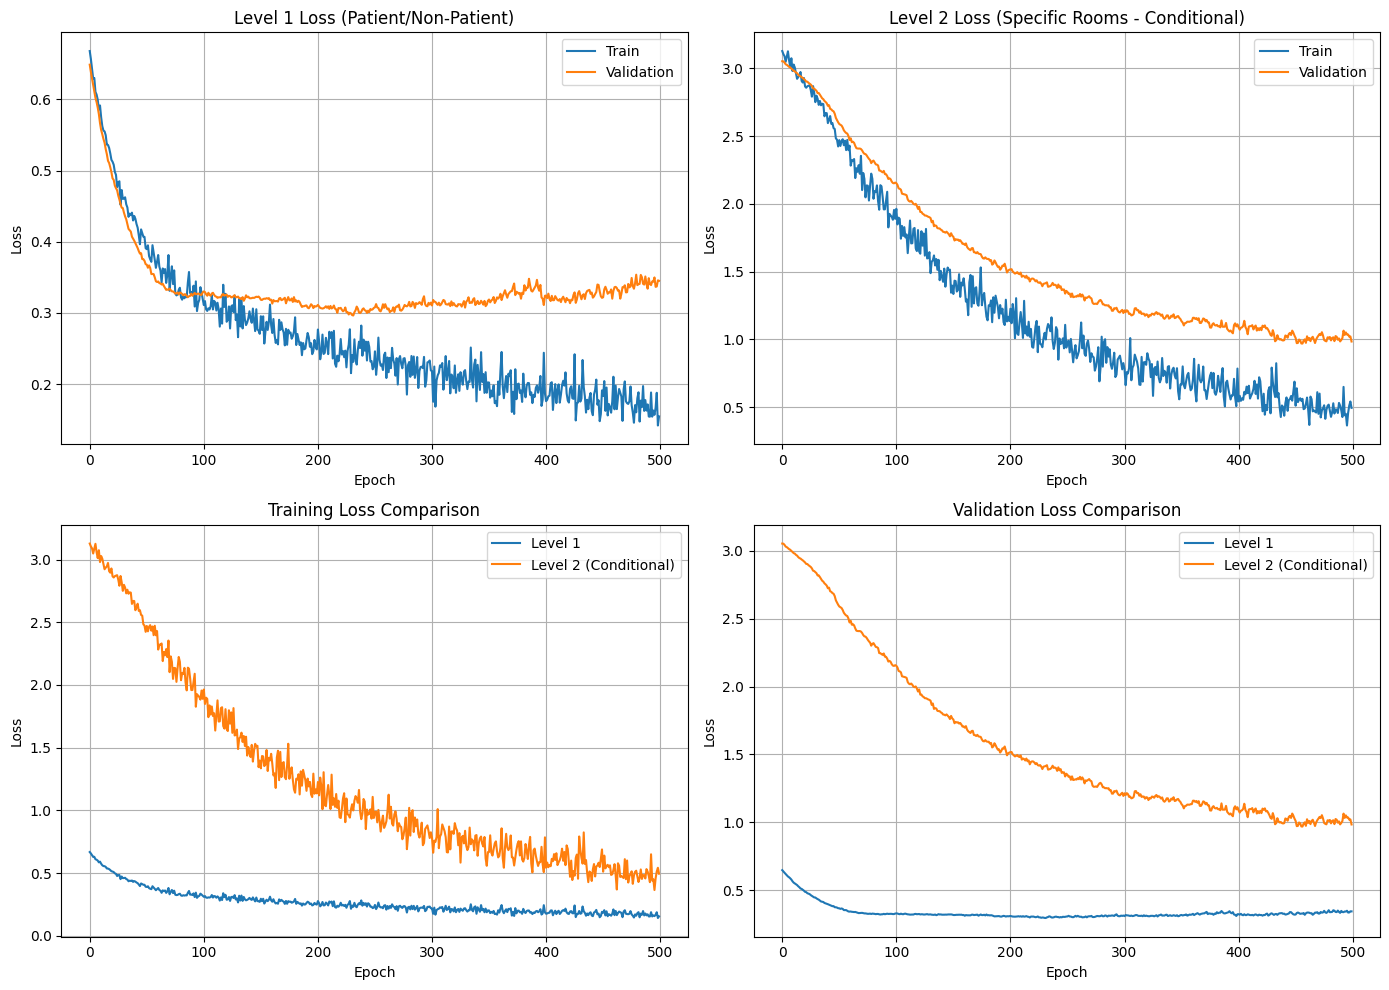


Loss curves saved as 'mlp_multihead_conditional_loss_curves.png'


In [23]:
if 'train_l1' in mlp_loss_curves:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    axes[0, 0].plot(mlp_loss_curves['train_l1'], label='Train')
    axes[0, 0].plot(mlp_loss_curves['val_l1'], label='Validation')
    axes[0, 0].set_title('Level 1 Loss (Patient/Non-Patient)')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    axes[0, 1].plot(mlp_loss_curves['train_l2'], label='Train')
    axes[0, 1].plot(mlp_loss_curves['val_l2'], label='Validation')
    axes[0, 1].set_title('Level 2 Loss (Specific Rooms - Conditional)')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    axes[1, 0].plot(mlp_loss_curves['train_l1'], label='Level 1')
    axes[1, 0].plot(mlp_loss_curves['train_l2'], label='Level 2 (Conditional)')
    axes[1, 0].set_title('Training Loss Comparison')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Loss')
    axes[1, 0].legend()
    axes[1, 0].grid(True)
    
    axes[1, 1].plot(mlp_loss_curves['val_l1'], label='Level 1')
    axes[1, 1].plot(mlp_loss_curves['val_l2'], label='Level 2 (Conditional)')
    axes[1, 1].set_title('Validation Loss Comparison')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Loss')
    axes[1, 1].legend()
    axes[1, 1].grid(True)
    
    plt.tight_layout()
    plt.savefig('../results/mlp_multihead_conditional_loss_curves.png', dpi=600, bbox_inches='tight')
    plt.show()
    
    print("\nLoss curves saved as 'mlp_multihead_conditional_loss_curves.png'")

#### GRU

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [25]:
class GRUMultiHead(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, n_classes_l1=2, n_classes_l2=4):
        super().__init__()

        self.gru = nn.GRU(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=1,
            batch_first=True,
            bidirectional=False
        )

        self.norm = nn.LayerNorm(hidden_dim)
        self.dropout = nn.Dropout(0.2)

        self.head_l1 = nn.Linear(hidden_dim, n_classes_l1)
        self.head_l2 = nn.Linear(hidden_dim, n_classes_l2)

    def forward(self, x):
        x = x.unsqueeze(1)

        out, _ = self.gru(x)
        features = out[:, -1, :]

        features = self.norm(features)
        features = self.dropout(features)

        return self.head_l1(features), self.head_l2(features)


In [26]:
INPUT_DIM = X_train_scaled.shape[1]
HIDDEN_DIM = 128
N_CLASSES_L1 = len(np.unique(y_l1_train))
N_CLASSES_L2 = len(np.unique(y_l2_train))
PATIENT_ROOM_IDX = le_level1.transform(['Patient Room'])[0]

model_gru = GRUMultiHead(INPUT_DIM, HIDDEN_DIM, N_CLASSES_L1, N_CLASSES_L2).to(device)

In [27]:
trained_gru, gru_losses = train_multihead_conditional(
    X_train_scaled, y_l1_train, y_l2_train,
    X_val_scaled, y_l1_val, y_l2_val,
    N_CLASSES_L1, N_CLASSES_L2, PATIENT_ROOM_IDX,
    epochs=500, batch_size=64, lr=0.001
)

Using device: cuda

Multi-Head Model Architecture:
Output Head 1 (Level 1): 2 classes (Patient/Non-Patient)
Output Head 2 (Level 2): 20 classes (Specific Rooms)

Conditional Loss: Head 2 loss ONLY computed for Patient Room samples
Epoch 50: Train L1=0.2169, L2=0.6304 | Val L1=0.2602, L2=1.0425
Epoch 100: Train L1=0.2059, L2=0.3764 | Val L1=0.3586, L2=0.5157
Epoch 150: Train L1=0.1213, L2=0.1998 | Val L1=0.4596, L2=0.3386
Epoch 200: Train L1=0.0696, L2=0.1163 | Val L1=0.5122, L2=0.4631
Epoch 250: Train L1=0.0537, L2=0.1944 | Val L1=0.5537, L2=0.7267
Epoch 300: Train L1=0.0726, L2=0.0753 | Val L1=0.6272, L2=0.6048
Epoch 350: Train L1=0.0574, L2=0.1138 | Val L1=0.6673, L2=0.5361
Epoch 400: Train L1=0.0444, L2=0.1110 | Val L1=0.6686, L2=0.5895
Epoch 450: Train L1=0.0291, L2=0.0907 | Val L1=0.7447, L2=0.6655
Epoch 500: Train L1=0.0441, L2=0.0944 | Val L1=0.8479, L2=0.8639


In [28]:
def predict_and_score(model, X_data, y_l1_true, y_l2_true):
    l1_pred, l2_pred = predict_multihead(model, X_data) 
    acc_l1 = accuracy_score(y_l1_true, l1_pred)
    f1_l1 = f1_score(y_l1_true, l1_pred, average='weighted')
    
    final_preds = []
    final_true = []

    for i in range(len(l1_pred)):
        final_preds.append(l2_pred[i])
        final_true.append(y_l2_true[i])
        
    acc_l2 = accuracy_score(final_true, final_preds)
    f1_l2 = f1_score(final_true, final_preds, average='macro')
    
    return acc_l1, f1_l1, acc_l2, f1_l2

In [29]:
val_acc1, val_f1_1, val_acc2, val_f1_2 = predict_and_score(trained_gru, X_val_scaled, y_l1_val, y_l2_val)
test_acc1, test_f1_1, test_acc2, test_f1_2 = predict_and_score(trained_gru, X_test_scaled, y_l1_test, y_l2_test)

In [30]:
def get_metrics(model, X, y_l1_true, y_l2_true, set_name):
    l1_pred, l2_pred = predict_multihead(model, X)
    l1_pred = l1_pred.astype(int)
    l2_pred = l2_pred.astype(int)
    
    l1_pred_str = le_level1.inverse_transform(l1_pred)
    l2_pred_str = le_level2.inverse_transform(l2_pred)
    
    final_l2_pred_str = []
    for i in range(len(l1_pred)):
        if l1_pred_str[i] == 'Non-Patient Room':
            final_l2_pred_str.append('Non-Patient Room')
        else:
            final_l2_pred_str.append(l2_pred_str[i])

    y_l1_true_str = le_level1.inverse_transform(y_l1_true)
    y_l2_true_str = le_level2.inverse_transform(y_l2_true)
    
    final_l2_true_str = []
    for i in range(len(y_l1_true)):
        if y_l1_true_str[i] == 'Non-Patient Room':
            final_l2_true_str.append('Non-Patient Room')
        else:
            final_l2_true_str.append(y_l2_true_str[i])
    
    rows = []
    
    rows.append({
        'model': 'GRU',
        'set': set_name,
        'eval_type': 'All samples',
        'n_samples': len(y_l1_true),
        'l1_acc': accuracy_score(y_l1_true, l1_pred), 
        'l1_f1': f1_score(y_l1_true, l1_pred, average='weighted'),
        'l2_acc': accuracy_score(final_l2_true_str, final_l2_pred_str),
        'l2_precision': precision_score(final_l2_true_str, final_l2_pred_str, average='weighted', zero_division=0),
        'l2_recall': recall_score(final_l2_true_str, final_l2_pred_str, average='weighted', zero_division=0),
        'l2_f1': f1_score(final_l2_true_str, final_l2_pred_str, average='weighted', zero_division=0),
        'l2_f1_macro': f1_score(final_l2_true_str, final_l2_pred_str, average='macro', zero_division=0)
    })
    
    mask = (y_l1_true == l1_pred)
    if mask.sum() > 0:
        true_filt = np.array(final_l2_true_str)[mask]
        pred_filt = np.array(final_l2_pred_str)[mask]
        
        rows.append({
            'model': 'GRU',
            'set': set_name,
            'eval_type': 'L1 correct only',
            'n_samples': mask.sum(),
            'l1_acc': 1.0, 
            'l1_f1': 1.0,
            'l2_acc': accuracy_score(true_filt, pred_filt),
            'l2_precision': precision_score(true_filt, pred_filt, average='weighted', zero_division=0),
            'l2_recall': recall_score(true_filt, pred_filt, average='weighted', zero_division=0),
            'l2_f1': f1_score(true_filt, pred_filt, average='weighted', zero_division=0),
            'l2_f1_macro': f1_score(true_filt, pred_filt, average='macro', zero_division=0)
        })
        
    return rows

In [31]:
val_rows = get_metrics(trained_gru, X_val_scaled, y_l1_val, y_l2_val, 'Validation')
test_rows = get_metrics(trained_gru, X_test_scaled, y_l1_test, y_l2_test, 'Test')
gru_df = pd.DataFrame(val_rows + test_rows)
results_df = pd.concat([results_df, gru_df], ignore_index=True)

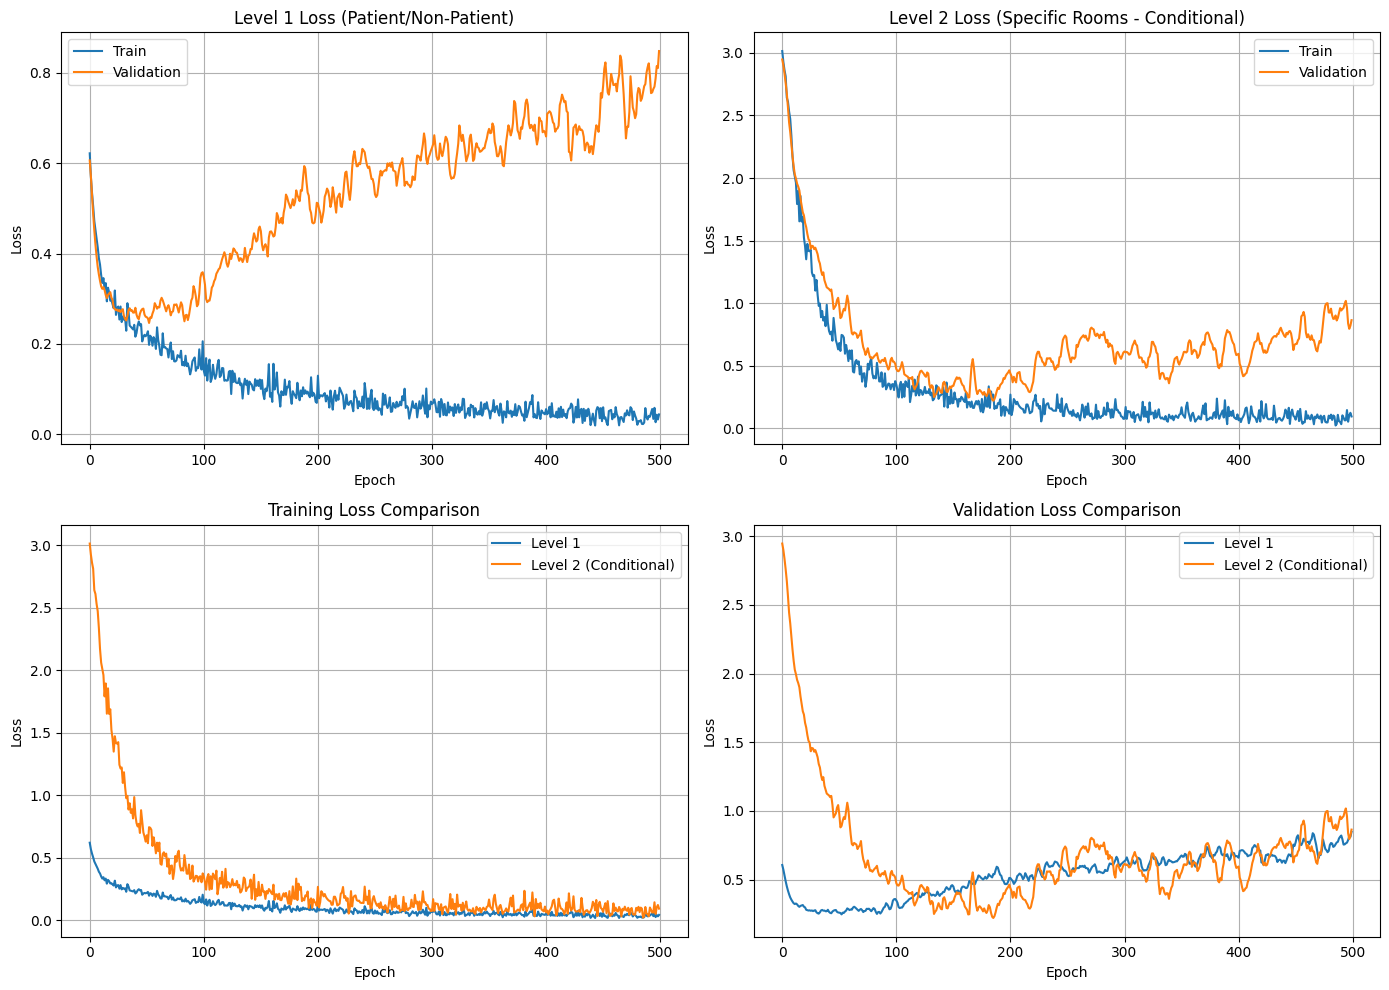

In [32]:
if 'train_l1' in gru_losses:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    axes[0, 0].plot(gru_losses['train_l1'], label='Train')
    axes[0, 0].plot(gru_losses['val_l1'], label='Validation')
    axes[0, 0].set_title('Level 1 Loss (Patient/Non-Patient)')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    axes[0, 1].plot(gru_losses['train_l2'], label='Train')
    axes[0, 1].plot(gru_losses['val_l2'], label='Validation')
    axes[0, 1].set_title('Level 2 Loss (Specific Rooms - Conditional)')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    axes[1, 0].plot(gru_losses['train_l1'], label='Level 1')
    axes[1, 0].plot(gru_losses['train_l2'], label='Level 2 (Conditional)')
    axes[1, 0].set_title('Training Loss Comparison')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Loss')
    axes[1, 0].legend()
    axes[1, 0].grid(True)
    
    axes[1, 1].plot(gru_losses['val_l1'], label='Level 1')
    axes[1, 1].plot(gru_losses['val_l2'], label='Level 2 (Conditional)')
    axes[1, 1].set_title('Validation Loss Comparison')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Loss')
    axes[1, 1].legend()
    axes[1, 1].grid(True)
    
    plt.tight_layout()
    plt.savefig('../results/gru_multihead_conditional_loss_curves.png', dpi=600, bbox_inches='tight')
    plt.show()

In [33]:
results_df

,model,set,eval_type,n_samples,l1_acc,l1_f1,l2_acc,l2_precision,l2_recall,l2_f1,l2_f1_macro
0,DT,Validation,All samples,71,0.915493,0.915493,0.901408,0.887324,0.901408,0.892019,0.585892
1,DT,Validation,L1 correct only,65,0.915493,0.915493,0.984615,0.984615,0.984615,0.984615,0.800000
2,DT,Test,All samples,142,0.915493,0.916576,0.852113,0.861041,0.852113,0.846779,0.472907
3,DT,Test,L1 correct only,130,0.915493,0.916576,0.930769,0.916550,0.930769,0.920000,0.557576
4,RF,Validation,All samples,71,0.859155,0.843470,0.859155,0.787726,0.859155,0.819752,0.468615
5,RF,Validation,L1 correct only,61,0.859155,0.843470,1.000000,1.000000,1.000000,1.000000,1.000000
6,RF,Test,All samples,142,0.901408,0.894864,0.873239,0.802967,0.873239,0.833411,0.378592
7,RF,Test,L1 correct only,128,0.901408,0.894864,0.968750,0.946875,0.968750,0.955946,0.662698
8,HGBC,Validation,All samples,71,0.901408,0.896757,0.873239,0.836854,0.873239,0.852706,0.431522
9,HGBC,Validation,L1 correct only,64,0.901408,0.896757,0.968750,0.968750,0.968750,0.968750,0.666667


#### LSTM

In [34]:
import torch
import torch.nn as nn

class LSTMMultiHead(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, n_classes_l1=2, n_classes_l2=4):
        super().__init__()

        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=1,
            batch_first=True,
            bidirectional=False
        )

        self.norm = nn.LayerNorm(hidden_dim)
        self.dropout = nn.Dropout(0.2)

        self.head_l1 = nn.Linear(hidden_dim, n_classes_l1)
        self.head_l2 = nn.Linear(hidden_dim, n_classes_l2)

    def forward(self, x):
        x = x.unsqueeze(1)

        self.lstm.flatten_parameters()
        out, _ = self.lstm(x)

        features = out[:, -1, :]
        features = self.norm(features)
        features = self.dropout(features)

        return self.head_l1(features), self.head_l2(features)

In [35]:
HIDDEN_DIM_LSTM = 128
model_lstm = LSTMMultiHead(INPUT_DIM, HIDDEN_DIM_LSTM, N_CLASSES_L1, N_CLASSES_L2).to(device)

In [36]:
trained_lstm, lstm_losses = train_multihead_conditional(
    X_train_scaled, y_l1_train, y_l2_train,
    X_val_scaled, y_l1_val, y_l2_val,
    N_CLASSES_L1, N_CLASSES_L2, PATIENT_ROOM_IDX,
    epochs=500, batch_size=64, lr=0.001
)

Using device: cuda

Multi-Head Model Architecture:
Output Head 1 (Level 1): 2 classes (Patient/Non-Patient)
Output Head 2 (Level 2): 20 classes (Specific Rooms)

Conditional Loss: Head 2 loss ONLY computed for Patient Room samples
Epoch 50: Train L1=0.2222, L2=0.6391 | Val L1=0.2330, L2=1.0388
Epoch 100: Train L1=0.1598, L2=0.3356 | Val L1=0.3371, L2=0.9084
Epoch 150: Train L1=0.0999, L2=0.1026 | Val L1=0.2795, L2=0.7867
Epoch 200: Train L1=0.0827, L2=0.2482 | Val L1=0.3465, L2=0.8434
Epoch 250: Train L1=0.0639, L2=0.1069 | Val L1=0.4452, L2=0.8629
Epoch 300: Train L1=0.0493, L2=0.2961 | Val L1=0.5129, L2=0.8412
Epoch 350: Train L1=0.0526, L2=0.1636 | Val L1=0.5591, L2=1.0633
Epoch 400: Train L1=0.0495, L2=0.1515 | Val L1=0.5420, L2=1.2548
Epoch 450: Train L1=0.0806, L2=0.0676 | Val L1=0.5519, L2=1.2805
Epoch 500: Train L1=0.0239, L2=0.0428 | Val L1=0.5831, L2=1.4184


In [37]:
val_rows_lstm = get_metrics(trained_lstm, X_val_scaled, y_l1_val, y_l2_val, 'Validation')
for row in val_rows_lstm: row['model'] = 'LSTM'

test_rows_lstm = get_metrics(trained_lstm, X_test_scaled, y_l1_test, y_l2_test, 'Test')
for row in test_rows_lstm: row['model'] = 'LSTM'

lstm_df = pd.DataFrame(val_rows_lstm + test_rows_lstm)
results_df = pd.concat([results_df, lstm_df], ignore_index=True)

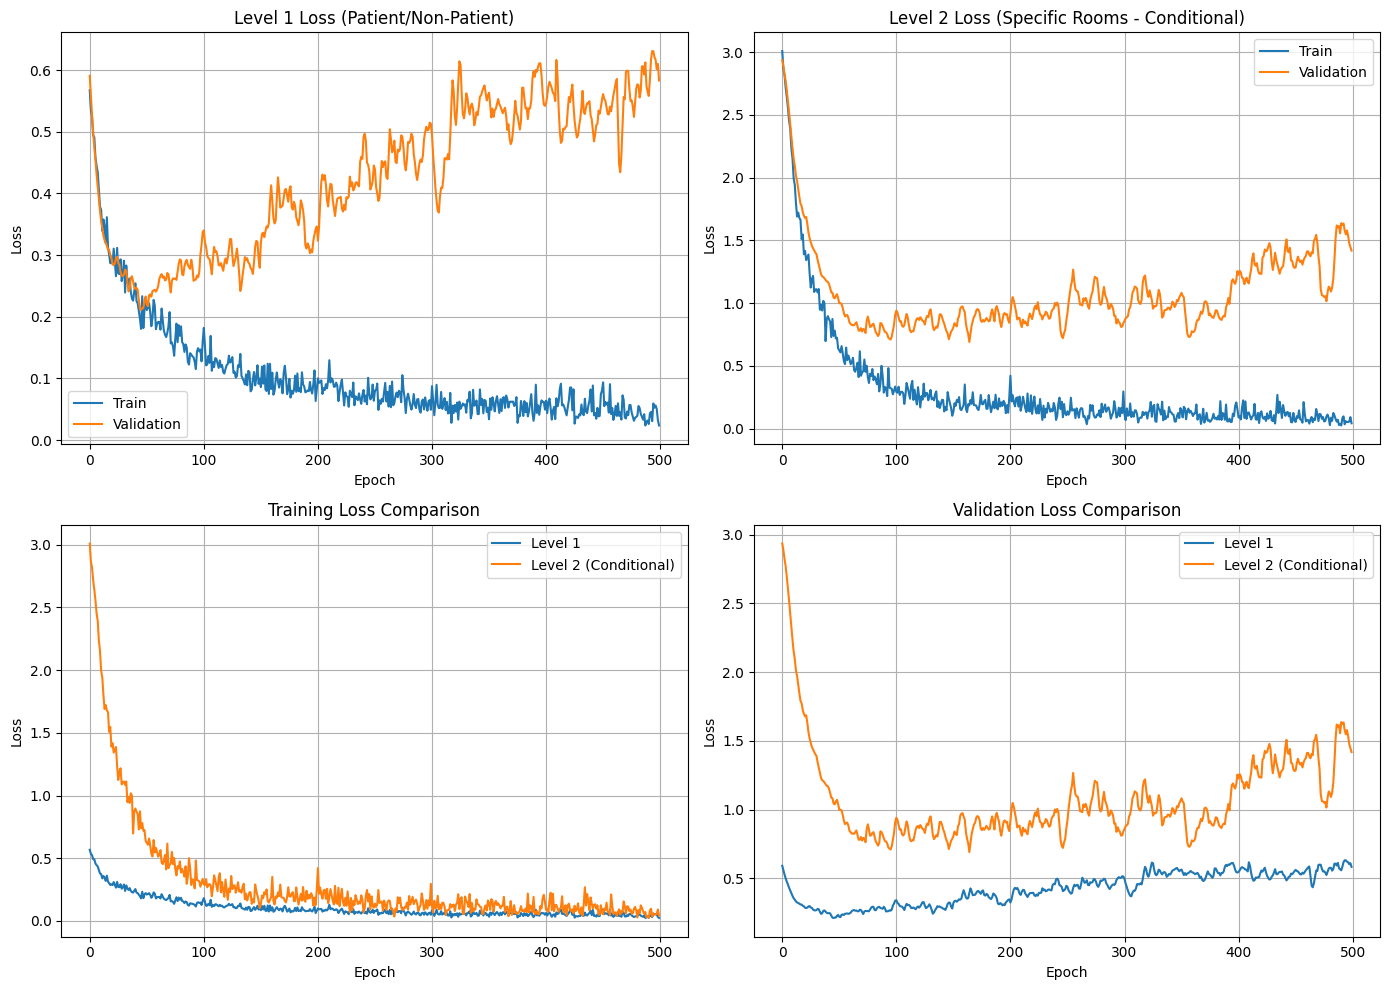

In [38]:
if 'train_l1' in lstm_losses:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    axes[0, 0].plot(lstm_losses['train_l1'], label='Train')
    axes[0, 0].plot(lstm_losses['val_l1'], label='Validation')
    axes[0, 0].set_title('Level 1 Loss (Patient/Non-Patient)')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    axes[0, 1].plot(lstm_losses['train_l2'], label='Train')
    axes[0, 1].plot(lstm_losses['val_l2'], label='Validation')
    axes[0, 1].set_title('Level 2 Loss (Specific Rooms - Conditional)')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    axes[1, 0].plot(lstm_losses['train_l1'], label='Level 1')
    axes[1, 0].plot(lstm_losses['train_l2'], label='Level 2 (Conditional)')
    axes[1, 0].set_title('Training Loss Comparison')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Loss')
    axes[1, 0].legend()
    axes[1, 0].grid(True)
    
    axes[1, 1].plot(lstm_losses['val_l1'], label='Level 1')
    axes[1, 1].plot(lstm_losses['val_l2'], label='Level 2 (Conditional)')
    axes[1, 1].set_title('Validation Loss Comparison')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Loss')
    axes[1, 1].legend()
    axes[1, 1].grid(True)
    
    plt.tight_layout()
    plt.savefig('../results/lstm_multihead_conditional_loss_curves.png', dpi=600, bbox_inches='tight')
    plt.show()

In [39]:
results_df

,model,set,eval_type,n_samples,l1_acc,l1_f1,l2_acc,l2_precision,l2_recall,l2_f1,l2_f1_macro
0,DT,Validation,All samples,71,0.915493,0.915493,0.901408,0.887324,0.901408,0.892019,0.585892
1,DT,Validation,L1 correct only,65,0.915493,0.915493,0.984615,0.984615,0.984615,0.984615,0.800000
2,DT,Test,All samples,142,0.915493,0.916576,0.852113,0.861041,0.852113,0.846779,0.472907
3,DT,Test,L1 correct only,130,0.915493,0.916576,0.930769,0.916550,0.930769,0.920000,0.557576
4,RF,Validation,All samples,71,0.859155,0.843470,0.859155,0.787726,0.859155,0.819752,0.468615
5,RF,Validation,L1 correct only,61,0.859155,0.843470,1.000000,1.000000,1.000000,1.000000,1.000000
6,RF,Test,All samples,142,0.901408,0.894864,0.873239,0.802967,0.873239,0.833411,0.378592
7,RF,Test,L1 correct only,128,0.901408,0.894864,0.968750,0.946875,0.968750,0.955946,0.662698
8,HGBC,Validation,All samples,71,0.901408,0.896757,0.873239,0.836854,0.873239,0.852706,0.431522
9,HGBC,Validation,L1 correct only,64,0.901408,0.896757,0.968750,0.968750,0.968750,0.968750,0.666667


## Prediction

In [2]:
test = pd.read_csv('../../Dataset/BLE_Test_predict.csv')

In [ ]:
print(test.head)

,user_id,timestamp,mac address,RSSI,power,window_start
0,90,2023-04-14 19:01:40+09:00,D4:33:FD:F4:C2:A8,-97,-2147483648,2023-04-14 19:01:30+09:00


### Preprocessing

In [3]:
test['timestamp'] = pd.to_datetime(test['timestamp'], errors='coerce')
test = test[test['timestamp'].notna()]

In [4]:
test['timestamp'] = test['timestamp'].dt.tz_localize('UTC').dt.tz_convert('Asia/Tokyo')

In [5]:
test = test.sort_values('timestamp').reset_index(drop=True)

In [6]:
test = test.drop(columns=['Unnamed: 0'])

In [7]:
mac_list = [
    'F7:7F:78:76:7E:F3', 'C6:CD:5E:3D:2F:BB', 'D6:F4:3A:79:74:63', 'C9:17:55:E2:3E:0E',
    'CA:60:AB:EE:EC:7F', 'D6:51:7F:AB:0E:29', 'CC:54:33:F6:A7:90', 'EB:20:56:87:04:5A',
    'EE:E7:46:DC:19:6F', 'C8:5B:BF:37:07:A0', 'D7:26:F6:A3:44:D2', 'DD:83:B0:27:FD:36',
    'E5:CD:4A:36:87:06', 'DC:22:B8:17:4E:B5', 'EA:09:20:80:D6:44', 'E6:99:D1:EC:C6:81',
    'F6:DA:97:C7:D5:28', 'EA:66:A1:12:2C:F4', 'C9:EA:57:8B:0F:80', 'D6:7C:1D:2C:2A:0A',
    'DA:E1:70:5F:44:97', 'DD:10:10:F6:4F:27', 'E6:F3:93:A8:9E:22', 'E6:60:05:1F:88:F9',
    'D4:33:FD:F4:C2:A8'
]

sorted_macs = sorted(mac_list)
mac_mapper = {i+1: mac for i, mac in enumerate(sorted_macs)}

test['mac address'] = test['mac address'].map(mac_mapper)

test = test[test['mac address'].isin(mac_list)]
test = test.sort_values('timestamp').reset_index(drop=True)

In [8]:
WINDOW = '45s'
test['window_start'] = test['timestamp'].dt.floor(WINDOW)

In [9]:
agg_funcs = ['min', 'max', 'count']

feat_test = (
    test
    .groupby(['window_start', 'mac address'])['RSSI']
    .agg(agg_funcs)
    .unstack('mac address')
)

feat_test.columns = [f'{mac}_{stat}' for stat, mac in feat_test.columns]
feat_test = feat_test.reset_index()

In [10]:
feat_test['hour'] = feat_test['window_start'].dt.hour
feat_test['minute'] = feat_test['window_start'].dt.minute
feat_test['second'] = feat_test['window_start'].dt.second

In [11]:
feat_test.columns = (
    feat_test.columns
    .str.replace(':', '_', regex=False)
    .str.replace('-', '_', regex=False)
    .str.replace(' ', '_', regex=False)
)

In [27]:
train_features = X.columns

In [28]:
X_test_pred = pd.DataFrame(index=feat_test.index)

In [29]:
for col in train_features:
    if col in feat_test.columns:
        X_test_pred[col] = feat_test[col]
    else:
        X_test_pred[col] = -100 

X_test_pred = X_test_pred.fillna(-100)

In [30]:
X_test_pred = X_test_pred.fillna(-100)

### Model & Predict

In [31]:
model_xgb = models['XGBoost']

y_pred_enc = model_xgb.predict(X_test_pred)

In [32]:
y_pred_str = le.inverse_transform(y_pred_enc)

In [34]:
sub = pd.DataFrame({
    'window_start': feat_test['window_start'],
    'room': y_pred_str
})

In [38]:
final_sub = pd.merge(
    test,                
    sub,          
    on='window_start',   
    how='left'           
)

In [39]:
output = final_sub[['timestamp', 'mac address', 'RSSI', 'room']]

In [41]:
#output.to_csv('submission.csv', index=False)